In [1]:
import os, sys
sys.path.append("src/")
os.environ["CUDA_VISIBLE_DEVICES"] = "0,"
from argparse import Namespace
import math
import numpy as np
import lovely_tensors as lt
from einops import rearrange
from PIL import Image
import torch
from transformers import LlamaTokenizerFast, LlamaModel,CLIPTokenizer, CLIPTextModel
from accelerate import init_empty_weights

from musubi_tuner.dataset.image_video_dataset import resize_image_to_bucket
from musubi_tuner.frame_pack.uni_pc_fm import sample_unipc
from musubi_tuner.frame_pack.wrapper import fm_wrapper
from musubi_tuner.frame_pack.clip_vision import hf_clip_vision_encode
from musubi_tuner.frame_pack.framepack_utils import load_vae, load_text_encoder1, load_text_encoder2, load_image_encoders
from musubi_tuner.frame_pack.hunyuan import encode_prompt_conds, vae_encode, vae_decode
from musubi_tuner.frame_pack.hunyuan_video_packed import HunyuanVideoTransformer3DModelPacked
from musubi_tuner.utils.safetensors_utils import load_split_weights
# from musubi_tuner.frame_pack.k_diffusion_hunyuan import sample_hunyuan
from musubi_tuner.frame_pack.utils import crop_or_pad_yield_mask

lt.monkey_patch()
device = torch.device('cuda')

2025-06-26 21:03:29.607731: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:477] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
E0000 00:00:1750939409.627320   54922 cuda_dnn.cc:8310] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
E0000 00:00:1750939409.633074   54922 cuda_blas.cc:1418] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
2025-06-26 21:03:29.652813: I tensorflow/core/platform/cpu_feature_guard.cc:210] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.


Xformers is installed!
Flash Attn is installed!
Sage Attn is installed!


In [2]:
from types import SimpleNamespace
from einops import rearrange
import torch.nn as nn
from musubi_tuner.frame_pack.hunyuan_video_packed import HunyuanVideoPatchEmbed, HunyuanVideoTokenRefiner, CombinedTimestepGuidanceTextProjEmbeddings
from musubi_tuner.frame_pack.hunyuan_video_packed import HunyuanVideoRotaryPosEmbed, HunyuanVideoTransformerBlock, HunyuanVideoSingleTransformerBlock
from musubi_tuner.frame_pack.hunyuan_video_packed import AdaLayerNormContinuous, ClipVisionProjection, HunyuanVideoPatchEmbedForCleanLatents
from musubi_tuner.frame_pack.hunyuan_video_packed import pad_for_3d_conv, center_down_sample_3d

In [24]:
class Test_HunyuanVideoTransformer3DModelPacked(nn.Module):  # (PreTrainedModelMixin, GenerationMixin,
    # ModelMixin, ConfigMixin, PeftAdapterMixin, FromOriginalModelMixin):
    # @register_to_config
    def __init__(
        self,
        in_channels: int = 16,
        out_channels: int = 16,
        num_attention_heads: int = 24,
        attention_head_dim: int = 128,
        num_layers: int = 20,
        num_single_layers: int = 40,
        num_refiner_layers: int = 2,
        mlp_ratio: float = 4.0,
        patch_size: int = 2,
        patch_size_t: int = 1,
        qk_norm: str = "rms_norm",
        text_embed_dim: int = 4096,
        pooled_projection_dim: int = 768,
        rope_theta: float = 256.0,
        rope_axes_dim = (16, 56, 56),
        image_proj_dim=1152,
        attn_mode: str = None,
        split_attn: bool = False,
    ) -> None:
        super().__init__()

        inner_dim = num_attention_heads * attention_head_dim
        out_channels = out_channels or in_channels
        self.config_patch_size = patch_size
        self.config_patch_size_t = patch_size_t

        # 1. Latent and condition embedders
        self.x_embedder = HunyuanVideoPatchEmbed((patch_size_t, patch_size, patch_size), in_channels, inner_dim)
        self.context_embedder = HunyuanVideoTokenRefiner(
            text_embed_dim, num_attention_heads, attention_head_dim, num_layers=num_refiner_layers
        )
        self.time_text_embed = CombinedTimestepGuidanceTextProjEmbeddings(inner_dim, pooled_projection_dim)

        # 2. RoPE
        self.rope = HunyuanVideoRotaryPosEmbed(rope_axes_dim, rope_theta)

        # 3. Dual stream transformer blocks
        self.transformer_blocks = nn.ModuleList(
            [
                HunyuanVideoTransformerBlock(
                    num_attention_heads,
                    attention_head_dim,
                    mlp_ratio=mlp_ratio,
                    qk_norm=qk_norm,
                    attn_mode=attn_mode,
                    split_attn=split_attn,
                )
                for _ in range(num_layers)
            ]
        )

        # 4. Single stream transformer blocks
        self.single_transformer_blocks = nn.ModuleList(
            [
                HunyuanVideoSingleTransformerBlock(
                    num_attention_heads,
                    attention_head_dim,
                    mlp_ratio=mlp_ratio,
                    qk_norm=qk_norm,
                    attn_mode=attn_mode,
                    split_attn=split_attn,
                )
                for _ in range(num_single_layers)
            ]
        )

        # 5. Output projection
        self.norm_out = AdaLayerNormContinuous(inner_dim, inner_dim, elementwise_affine=False, eps=1e-6)
        self.proj_out = nn.Linear(inner_dim, patch_size_t * patch_size * patch_size * out_channels)
        self.inner_dim = inner_dim

        self.image_projection = ClipVisionProjection(in_channels=image_proj_dim, out_channels=self.inner_dim)
        self.clean_x_embedder = HunyuanVideoPatchEmbedForCleanLatents(self.inner_dim)

    def process_input_hidden_states(
        self,
        latents,
        latent_indices=None,
        clean_latents=None,
        clean_latent_indices=None,
    ):
        hidden_states = self.x_embedder.proj(latents)
        B, C, T, H, W = hidden_states.shape
        hidden_states = hidden_states.flatten(2).transpose(1, 2)

        rope_freqs = self.rope(frame_indices=latent_indices, height=H, width=W, device=hidden_states.device)
        rope_freqs = rope_freqs.flatten(2).transpose(1, 2)

        clean_latents = clean_latents.to(hidden_states)
        clean_latents = self.clean_x_embedder.proj(clean_latents)
        clean_latents = clean_latents.flatten(2).transpose(1, 2)

        clean_latent_rope_freqs = self.rope(frame_indices=clean_latent_indices, height=H, width=W, device=clean_latents.device)
        clean_latent_rope_freqs = clean_latent_rope_freqs.flatten(2).transpose(1, 2)

        hidden_states = torch.cat([clean_latents, hidden_states], dim=1)
        rope_freqs = torch.cat([clean_latent_rope_freqs, rope_freqs], dim=1)

        return hidden_states, rope_freqs

    def forward(
        self,
        hidden_states,
        timestep,
        encoder_hidden_states,
        encoder_attention_mask,
        pooled_projections,
        guidance,
        latent_indices=None,
        clean_latents=None,
        clean_latent_indices=None,
        image_embeddings=None,
        attention_kwargs=None,
        return_dict=True,
    ):

        if attention_kwargs is None:
            attention_kwargs = {}

        batch_size, num_channels, num_frames, height, width = hidden_states.shape
        p, p_t = self.config_patch_size, self.config_patch_size_t
        post_patch_num_frames = num_frames // p_t
        post_patch_height = height // p
        post_patch_width = width // p
        original_context_length = post_patch_num_frames * post_patch_height * post_patch_width

        hidden_states, rope_freqs = self.process_input_hidden_states(
            hidden_states,
            latent_indices,
            clean_latents,
            clean_latent_indices,
        )
        del (
            latent_indices,
            clean_latents,
            clean_latent_indices,
        )  # free memory

        temb = self.time_text_embed(timestep, guidance, pooled_projections)

        print(encoder_hidden_states)
        print(timestep)
        print(encoder_attention_mask)
        encoder_hidden_states = self.context_embedder(
            encoder_hidden_states, timestep, encoder_attention_mask
        )
        print(encoder_hidden_states)

        extra_encoder_hidden_states = self.image_projection(image_embeddings)
        extra_attention_mask = torch.ones(
            (batch_size, extra_encoder_hidden_states.shape[1]),
            dtype=encoder_attention_mask.dtype,
            device=encoder_attention_mask.device,
        )

        # must cat before (not after) encoder_hidden_states, due to attn masking
        encoder_hidden_states = torch.cat([extra_encoder_hidden_states, encoder_hidden_states], dim=1)
        encoder_attention_mask = torch.cat([extra_attention_mask, encoder_attention_mask], dim=1)
        del extra_encoder_hidden_states, extra_attention_mask  # free memory

        with torch.no_grad():
            text_len = encoder_attention_mask.sum().item()
            encoder_hidden_states = encoder_hidden_states[:, :text_len]
            attention_mask = None, None, None, None
        del encoder_attention_mask  # free memory

        for block_id, block in enumerate(self.transformer_blocks):
            hidden_states, encoder_hidden_states = block(
                hidden_states, encoder_hidden_states, temb, attention_mask, rope_freqs
            )
        for block_id, block in enumerate(self.single_transformer_blocks):
            hidden_states, encoder_hidden_states = block(
                hidden_states, encoder_hidden_states, temb, attention_mask, rope_freqs
            )
        del attention_mask, rope_freqs  # free memory
        del encoder_hidden_states  # free memory

        hidden_states = self.norm_out(hidden_states, temb)
        hidden_states = hidden_states[:, -original_context_length:, :].to(dtype=torch.float32)
        self.proj_out.to(dtype=torch.float32)
        hidden_states = self.proj_out(hidden_states)

        hidden_states = rearrange(
            hidden_states,
            "b (t h w) (c pt ph pw) -> b c (t pt) (h ph) (w pw)",
            t=post_patch_num_frames,
            h=post_patch_height,
            w=post_patch_width,
            pt=p_t,
            ph=p,
            pw=p,
        )

        if return_dict:
            return SimpleNamespace(sample=hidden_states)

        return (hidden_states,)

In [25]:
dit_path = "/data/stale/patrickkwon/video/stable-diffusion-webui/models/Hunyuan/FramePackI2V_HY_bf16.safetensors"

with init_empty_weights():
    model = Test_HunyuanVideoTransformer3DModelPacked(
        attention_head_dim=128, image_proj_dim=1152, in_channels=16, mlp_ratio=4.0, num_attention_heads=24,
        num_layers=20, num_refiner_layers=2, num_single_layers=40, out_channels=16,
        patch_size=2, patch_size_t=1, pooled_projection_dim=768, qk_norm="rms_norm",
        rope_axes_dim=(16, 56, 56), rope_theta=256.0, text_embed_dim=4096,
        attn_mode='sageattn', split_attn=False)
sd = load_split_weights(dit_path, device=device, disable_mmap=True)
_ = model.load_state_dict(sd, strict=True, assign=True)

model.to(device)
_ = model.eval().requires_grad_(False)

In [5]:
vae_path = "/data/stale/patrickkwon/video/stable-diffusion-webui/models/VAE/hunyuan-video-t2v-720p-vae.pt"
vae = load_vae(vae_path, 32, 128, device)

tokenizer1, text_encoder1 = load_text_encoder1(
    Namespace(**{'text_encoder1' : "/shared/video/ComfyUI/models/text_encoders/llava_llama3_fp16.safetensors"}),
    False, device 
)
tokenizer2, text_encoder2 = load_text_encoder2(
    Namespace(**{'text_encoder2' : "/shared/video/ComfyUI/models/text_encoders/clip_l.safetensors"})
)
feature_extractor, image_encoder = load_image_encoders(
    Namespace(**{'image_encoder' : "/shared/video/ComfyUI/models/clip_vision/sigclip_vision_patch14_384.safetensors"})
)

In [6]:
prompt = 'The girl in a school blazer in a classroom.'
height, width = 832, 480

image_path = "docs/kisekaeichi_start.png"
control_image_paths = ["docs/kisekaeichi_start.png", "docs/kisekaeichi_ref.png"]
control_image_mask_paths = ["docs/kisekaeichi_start_mask.png", "docs/kisekaeichi_ref_mask.png"]
one_frame_inference = {'control_index=0;10', 'no_2x', 'no_4x', 'no_post', 'target_index=1'}

### prepare_i2v_inputs --> prepare_text_inputs

In [7]:
with torch.no_grad():
    llama_vec, clip_l_pooler = encode_prompt_conds(
        prompt, text_encoder1, text_encoder2, tokenizer1, tokenizer2, custom_system_prompt=None
    )
    llama_vec = llama_vec.to(device, dtype=torch.bfloat16)
    clip_l_pooler = clip_l_pooler.to(device, dtype=torch.bfloat16)
    llama_vec, llama_attention_mask = crop_or_pad_yield_mask(llama_vec, length=512)

llama_vec_n = torch.zeros_like(llama_vec).to(device, dtype=torch.bfloat16)
clip_l_pooler_n  = torch.zeros_like(clip_l_pooler).to(device, dtype=torch.bfloat16)
llama_vec_n, llama_attention_mask_n = crop_or_pad_yield_mask(llama_vec_n, length=512)

### prepare_i2v_inputs --> prepare_img_inputs

In [8]:
# preprocess image:
def preproc_image(image_path):
    image_pil = Image.open(image_path).convert("RGB")
    image_np = resize_image_to_bucket(np.array(image_pil), (width, height))
    image_tensor = (torch.from_numpy(image_np).float() / 127.5 - 1.0).permute(2,0,1)[None, :, None]
    return image_tensor, image_np

def preproc_mask(mask_path):
    image_pil = Image.open(mask_path).convert("L")
    image_np = resize_image_to_bucket(np.array(image_pil), (width // 8, height // 8))
    image_tensor = (torch.from_numpy(image_np).float() / 255.0)[None, None, None, :, :]
    return image_tensor, image_np

img_tensor, img_np = preproc_image(image_path)
with torch.no_grad():
    image_encoder_output = hf_clip_vision_encode(img_np, feature_extractor, image_encoder)
image_encoder_last_hidden_state = image_encoder_output.last_hidden_state.to(device, dtype=torch.bfloat16)
# start_latent = vae_encode(img_tensor, vae).cpu()

latent_indices = torch.zeros((1, 1), dtype=torch.int64)  # 1x1 latent index for target image
latent_indices[:, 0] = 1 #Target Index : 1

control_latents, control_nps = [], []
for i, (control_image_path, control_mask_path) in enumerate(zip(control_image_paths, control_image_mask_paths)):
    img_tensor, img_np = preproc_image(control_image_path)
    img_latent = vae_encode(img_tensor, vae).cpu()
    
    mask_image, mask_np = preproc_mask(control_mask_path)
    img_latent = img_latent * mask_image
    control_latents.append(img_latent)
    control_nps.append(np.concatenate([img_np, resize_image_to_bucket(mask_np, (width, height))[..., None]], -1))
clean_latents = torch.cat(control_latents, dim=2)  # (1, 16, num_control_images, H//8, W//8)

# kisekaeichi and 1f-mc: both are using control images, but indices are different
clean_latent_indices = torch.zeros((1, len(control_image_paths)), dtype=torch.int64)
clean_latent_indices[:, 0] = 0
clean_latent_indices[:, 1] = 10 

### sample_hunyuan

In [9]:
def flux_time_shift(t, mu=1.15, sigma=1.0):
    return math.exp(mu) / (math.exp(mu) + (1 / t - 1) ** sigma)

def calculate_flux_mu(context_length, x1=256, y1=0.5, x2=4096, y2=1.15, exp_max=7.0):
    k = (y2 - y1) / (x2 - x1)
    b = y1 - k * x1
    mu = k * context_length + b
    mu = min(mu, math.log(exp_max))
    return mu

def get_flux_sigmas_from_mu(n, mu):
    sigmas = torch.linspace(1, 0, steps=n + 1)
    sigmas = flux_time_shift(sigmas, mu=mu)
    return sigmas

num_inference_steps=25
seed = 1234
generator = torch.Generator(device="cpu")
generator.manual_seed(seed)

latents = torch.randn((1, 16, 1, height // 8, width // 8), generator=generator).to(device=device, dtype=torch.float32)
seq_length = (height * width) // 256
mu = calculate_flux_mu(seq_length, exp_max=7.0) # math.log(shift) 1.9459... if seq_len is large, mu is clipped.
sigmas = get_flux_sigmas_from_mu(num_inference_steps, mu).to(device)

In [26]:
real_guidance_scale=1.0
distilled_guidance_scale=10.0
guidance_rescale=0.0

k_model = fm_wrapper(model)

distilled_guidance = torch.tensor([distilled_guidance_scale * 1000.0]).to(device=device, dtype=torch.bfloat16)
sampler_kwargs = dict(
    dtype=torch.bfloat16,
    cfg_scale=real_guidance_scale,
    cfg_rescale=guidance_rescale,
    concat_latent=None,
    positive=dict(
        pooled_projections=clip_l_pooler,
        encoder_hidden_states=llama_vec,
        encoder_attention_mask=llama_attention_mask,
        guidance=distilled_guidance,

        image_embeddings=image_encoder_last_hidden_state,
        latent_indices=latent_indices,
        clean_latents=clean_latents,
        clean_latent_indices=clean_latent_indices,
    ),
    negative=dict(
        pooled_projections=clip_l_pooler_n,
        encoder_hidden_states=llama_vec_n,
        encoder_attention_mask=llama_attention_mask_n,
        guidance=distilled_guidance,

        image_embeddings=image_encoder_last_hidden_state,
        latent_indices=latent_indices,
        clean_latents=clean_latents,
        clean_latent_indices=clean_latent_indices,
    ),
)

with torch.no_grad():
    results = sample_unipc(k_model, latents, sigmas, extra_args=sampler_kwargs, disable=False, callback=None)

  0%|          | 0/25 [00:00<?, ?it/s]

tensor[1, 512, 4096] bf16 n=2097152 (4Mb) x∈[-33.250, 7.125] μ=-0.000 σ=0.109 cuda:0
tensor[1] bf16 cuda:0 [1000.000]
tensor[1, 512] bool x∈[False, True] μ=0.023 σ=0.151 cuda:0
tensor[1, 512, 3072] bf16 n=1572864 (3Mb) x∈[-3.840e+03, 442.000] μ=-1.102 σ=50.250 cuda:0
tensor[1, 512, 4096] bf16 n=2097152 (4Mb) x∈[-33.250, 7.125] μ=-0.000 σ=0.109 cuda:0
tensor[1] bf16 cuda:0 [980.000]
tensor[1, 512] bool x∈[False, True] μ=0.023 σ=0.151 cuda:0
tensor[1, 512, 3072] bf16 n=1572864 (3Mb) x∈[-3.824e+03, 444.000] μ=-1.102 σ=50.500 cuda:0
tensor[1, 512, 4096] bf16 n=2097152 (4Mb) x∈[-33.250, 7.125] μ=-0.000 σ=0.109 cuda:0
tensor[1] bf16 cuda:0 [960.000]
tensor[1, 512] bool x∈[False, True] μ=0.023 σ=0.151 cuda:0
tensor[1, 512, 3072] bf16 n=1572864 (3Mb) x∈[-3.760e+03, 424.000] μ=-1.109 σ=50.000 cuda:0
tensor[1, 512, 4096] bf16 n=2097152 (4Mb) x∈[-33.250, 7.125] μ=-0.000 σ=0.109 cuda:0
tensor[1] bf16 cuda:0 [936.000]
tensor[1, 512] bool x∈[False, True] μ=0.023 σ=0.151 cuda:0
tensor[1, 512, 3072] b

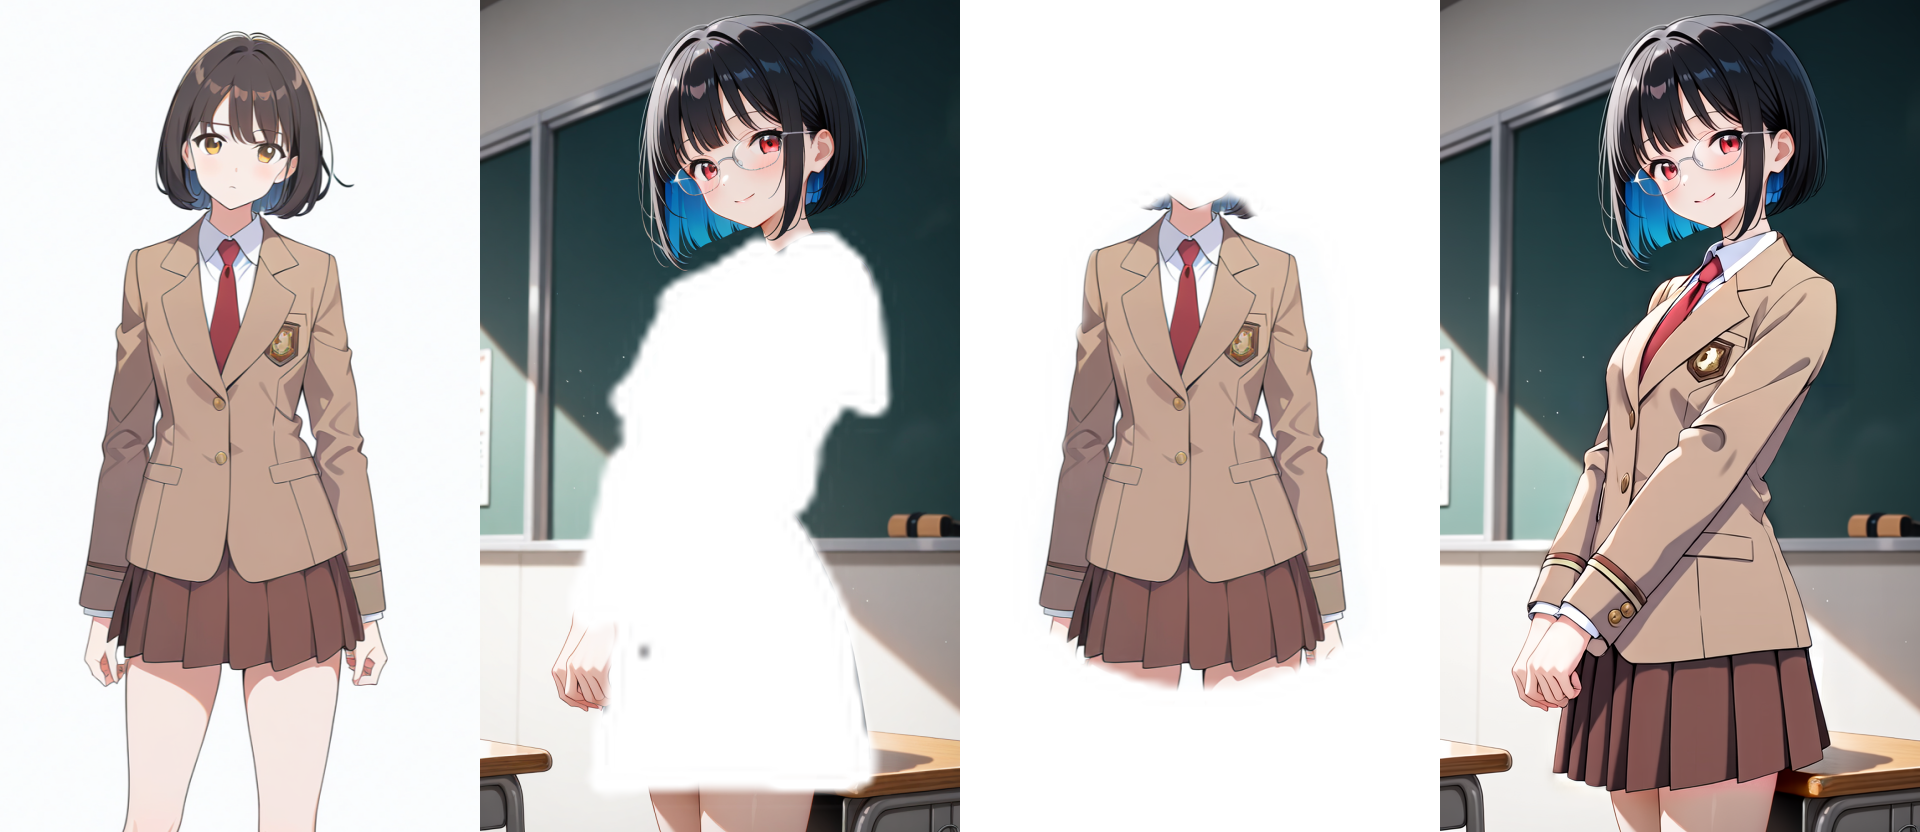

In [14]:

history_pixels = torch.cat([
    vae_decode(results[:, :, i:i + 1, :, :], vae).cpu() for i in range(results.shape[2])
], dim=2)
result_img = (torch.clamp(((history_pixels[0,:,0,:,:]+1.0)/2.0).permute(1,2,0).cpu(), 0.0, 1.0) * 255.).numpy().astype(np.uint8)

Image.fromarray(np.concatenate(
    [np.concatenate([img_np, np.ones(img_np.shape[:2] + (1, ))*255], axis=-1).astype(np.uint8)] + \
    control_nps + \
    [np.concatenate([result_img, np.ones(result_img.shape[:2] + (1, ))*255], axis=-1).astype(np.uint8)], 
axis=1))